In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

train = pd.read_csv('./processed-data/train.csv')
test = pd.read_csv('./processed-data/test.csv')
val = pd.read_csv('./processed-data/val.csv')

X_train = train['comment'].astype(str).tolist()
y_train = train['label'].astype(int).tolist()
X_test = test['comment'].astype(str).tolist()
y_test = test['label'].astype(int).tolist()
X_val = val['comment'].astype(str).tolist()
y_val = val['label'].astype(int).tolist()

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding to ensure equal sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=50, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=50, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=50, padding='post')

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Define model parameters
vocab_size = 10000      # Number of words in the vocabulary
embedding_dim = 128     # Size of the embedding vectors
max_length = 50         # Maximum length for padded sequences
num_classes = 8         # Number of emotion labels (change as needed)

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),  # First bidirectional layer with sequence output
    Bidirectional(LSTM(32)),                           # Second bidirectional layer (without sequence output)
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model structure
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 50, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 1422376 (5.43 MB)
Trainable params: 1422

In [5]:
y_train = np.array(y_train).astype(np.int32)
y_test = np.array(y_test).astype(np.int32)
y_val = np.array(y_val).astype(np.int32)

In [6]:
# Train the model
model.fit(X_train_pad, y_train, epochs=7, batch_size=32, validation_data=(X_val_pad, y_val))

Epoch 1/7


225/225 [==============================] - 16s 46ms/step - loss: 1.6688 - accuracy: 0.3706 - val_loss: 1.5976 - val_accuracy: 0.4375
Epoch 2/7
225/225 [==============================] - 9s 42ms/step - loss: 0.8653 - accuracy: 0.7167 - val_loss: 1.6584 - val_accuracy: 0.4563
Epoch 3/7
225/225 [==============================] - 9s 41ms/step - loss: 0.5454 - accuracy: 0.8265 - val_loss: 2.0384 - val_accuracy: 0.4225
Epoch 4/7
225/225 [==============================] - 9s 42ms/step - loss: 0.3725 - accuracy: 0.8826 - val_loss: 2.3272 - val_accuracy: 0.4387
Epoch 5/7
225/225 [==============================] - 10s 45ms/step - loss: 0.2739 - accuracy: 0.9197 - val_loss: 2.5685 - val_accuracy: 0.4187
Epoch 6/7
225/225 [==============================] - 11s 49ms/step - loss: 0.2031 - accuracy: 0.9411 - val_loss: 2.6585 - val_accuracy: 0.4325
Epoch 7/7
225/225 [==============================] - 11s 48ms/step - loss: 0.1661 - accuracy: 0.9533 - val_loss: 2.9289 - val_accuracy: 0.4275


25/25 [==============================] - 0s 10ms/step - loss: 2.5669 - accuracy: 0.4750
Test Loss: 2.5669, Test Accuracy: 0.4750
25/25 [==============================] - 1s 10ms/step


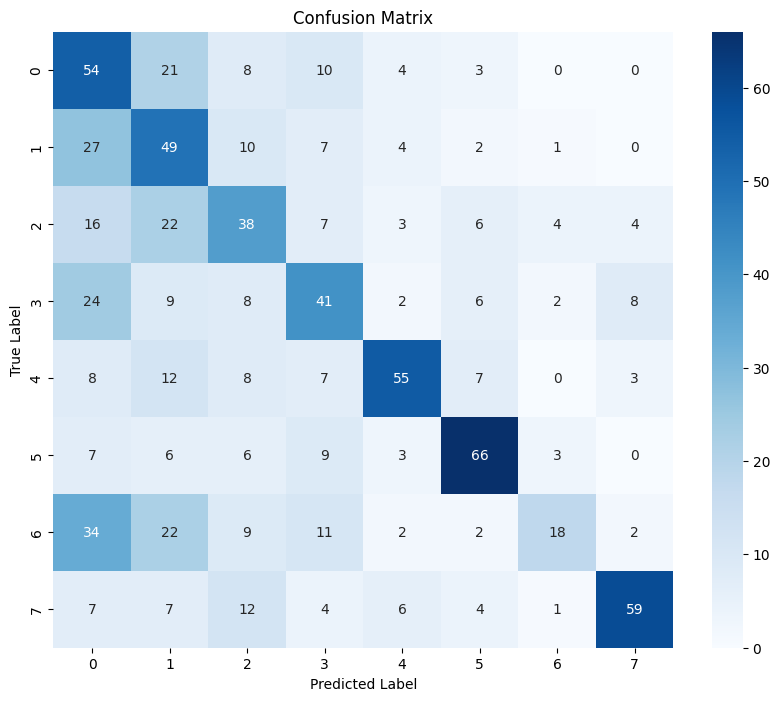

In [7]:
# Test the model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Make predictions
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Retest with an example
text = "bắt bỏ tù hết"
text_seq = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_seq, maxlen=50, padding='post')
# Predict the emotion for the example text
predicted_prob = model.predict(text_pad)
predicted_class = np.argmax(predicted_prob, axis=1)[0]
predicted_class

1/1 [==============================] - 0s 23ms/step


3

In [11]:
# Export the model and tokenizer
import joblib
joblib.dump(tokenizer, 'tokenizer.joblib')
model.save('emotion_detection_model.h5')

c:\Users\tungq\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
